## Evaluate Point Distance Results

In this notebook we examine two different metrics for registration results fitness:
1. Voxel overlap agreement (dice score)
2. Distance statistics describing the difference between annotation surfaces

General discussion on registration processes and label measures is available at http://aind-kitware-collab.s3-website-us-west-2.amazonaws.com/.

In [1]:
DISTANCE_RESULTS_FILEPATH = (
    r"..\data\results\652506\compare\distances_versus_overlap.csv"
)

In [7]:
import glob
import os
import re
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itk

itk.auto_progress(1)

import sys

sys.path.append("../src")
from aind_ccf_alignment_experiments.url import parse_sample_filepath

## Load and Examine Data

In [6]:
results_df = pd.read_csv(DISTANCE_RESULTS_FILEPATH)

if "Unnamed: 0" in results_df:
    del results_df["Unnamed: 0"]

results_df.head()

,subject_id,channel_id,experiment_id,registration_date,label_value,count,mean,std,min,median,max,abs_mean,abs_std,abs_min,abs_median,abs_max,ccf_label_name,ccf_label_value,dice_score
0,652506,Ex_445_Em_469,ANTS_L4,2023.06.04,473,43406,0.000528,0.044648,-0.099591,-9.335111e-03,0.159931,0.037191,0.024711,4.897538e-44,0.035195,0.159931,MH,473,0.664242
1,652506,Ex_445_Em_469,ANTS_L4,2023.06.04,585,16732,0.006558,0.053620,-0.089793,-9.322135e-03,0.149957,0.043102,0.032562,4.897538e-44,0.037139,0.149957,fr,585,0.321656
2,652506,Ex_445_Em_469,ANTS_L4,2023.06.04,788,19309,0.085237,0.062440,-0.066421,8.752170e-02,0.259457,0.088785,0.057284,4.897538e-44,0.087522,0.259457,VIIn,788,0.084610
3,652506,Ex_445_Em_469,ANTS_L4,2023.06.04,890,33700,0.009891,0.065179,-0.129312,1.314278e-43,0.194552,0.053899,0.037961,8.483461e-44,0.050464,0.194552,aco,890,0.109716
4,652506,Ex_445_Em_469,ANTS_L4,2023.06.04,-1,452588,0.018664,0.063621,-0.129312,9.264400e-03,0.259457,0.051846,0.041328,4.897538e-44,0.043398,0.259457,all,-1,0.248681


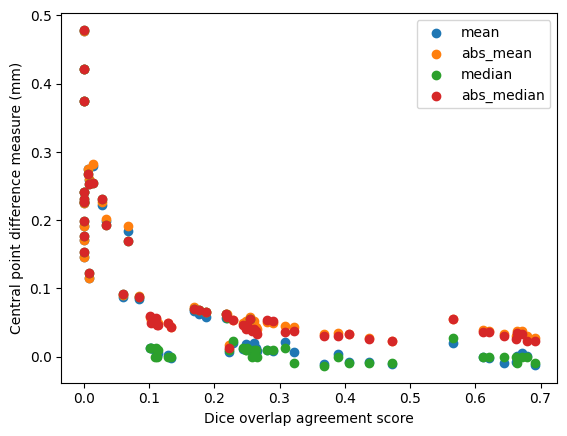

In [76]:
plt.scatter(results_df["dice_score"], results_df["mean"])
plt.scatter(results_df["dice_score"], results_df["abs_mean"])
plt.scatter(results_df["dice_score"], results_df["median"])
plt.scatter(results_df["dice_score"], results_df["abs_median"])
plt.xlabel("Dice overlap agreement score")
plt.ylabel("Central point difference measure (mm)")
plt.legend(["mean", "abs_mean", "median", "abs_median"])
plt.show()

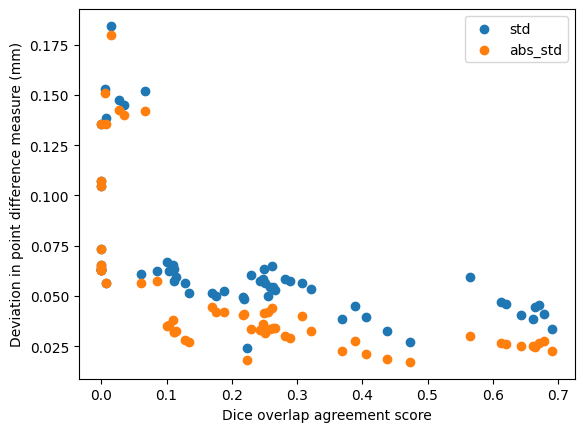

In [44]:
plt.scatter(results_df["dice_score"], results_df["std"])
plt.scatter(results_df["dice_score"], results_df["abs_std"])
plt.xlabel("Dice overlap agreement score")
plt.ylabel("Deviation in point difference measure (mm)")
plt.legend(["std", "abs_std"])
plt.show()

## Consider "best" results per dice overlap scores

In [197]:
best_dice_df = pd.DataFrame([], columns=results_df.columns)

for ccf_label_name in pd.unique(results_df["ccf_label_name"]):
    label_df = results_df[results_df["ccf_label_name"] == ccf_label_name]
    assert all(
        [
            row["ccf_label_name"] == ccf_label_name
            for _, row in label_df.iterrows()
        ]
    )
    result = label_df[label_df["dice_score"] == np.max(label_df["dice_score"])]
    if len(result) > 1:
        _, result = next(label_df.iterrows())
        result = pd.DataFrame(result).transpose()
    best_dice_df = pd.concat(
        [
            best_dice_df,
            result,
        ]
    )

best_dice_df

,subject_id,channel_id,experiment_id,registration_date,label_value,count,mean,std,min,median,max,abs_mean,abs_std,abs_min,abs_median,abs_max,ccf_label_name,ccf_label_value,dice_score
20,652506,Ex_488_Em_525,LEVEL_4,2023.06.01,473,39309,-0.011932,0.033436,-0.129582,-0.009335,0.087522,0.027307,0.022685,4.897538e-44,0.022753,0.129582,MH,473,0.691117
21,652506,Ex_488_Em_525,LEVEL_4,2023.06.01,585,17039,-0.010099,0.027166,-0.089793,-0.009354,0.063161,0.023361,0.017154,4.897538e-44,0.022742,0.089793,fr,585,0.472643
27,652506,Ex_561_Em_593,LEVEL_4,2023.06.01,788,19894,0.052205,0.050160,-0.067114,0.055586,0.197513,0.058846,0.042173,4.897538e-44,0.055586,0.197513,VIIn,788,0.255246
13,652506,Ex_561_Em_593,ANTS_L4,2023.06.04,890,43653,0.006505,0.024304,-0.127839,0.009264,0.089703,0.017338,0.018232,4.897538e-44,0.013406,0.127839,aco,890,0.223103
14,652506,Ex_561_Em_593,ANTS_L4,2023.06.04,-1,129764,0.021724,0.056264,-0.129582,0.013406,0.231848,0.044989,0.040170,4.897538e-44,0.036077,0.231848,all,-1,0.308331


In [25]:
best_dice = {}

best_dice["aco"] = results_df[
    (results_df["experiment_id"] == "ANTS_L4")
    & (results_df["channel_id"] == "Ex_561_Em_593")
    & (results_df["ccf_label_name"] == "aco")
]
best_dice["MH"] = results_df[
    (results_df["experiment_id"] == "LEVEL_4")
    & (results_df["channel_id"] == "Ex_488_Em_525")
    & (results_df["ccf_label_name"] == "MH")
]
best_dice["fr"] = results_df[
    (results_df["experiment_id"] == "LEVEL_4")
    & (results_df["channel_id"] == "Ex_488_Em_525")
    & (results_df["ccf_label_name"] == "fr")
]
best_dice["VIIn"] = results_df[
    (results_df["experiment_id"] == "LEVEL_4")
    & (results_df["channel_id"] == "Ex_561_Em_593")
    & (results_df["ccf_label_name"] == "VIIn")
]

In [35]:
best_dice_df = pd.DataFrame([], columns=results_df.columns)

for result in best_dice.values():
    best_dice_df = pd.concat([best_dice_df, result])

best_dice_df.head()

,subject_id,channel_id,experiment_id,registration_date,label_value,count,mean,std,min,median,max,abs_mean,abs_std,abs_min,abs_median,abs_max,ccf_label_name,ccf_label_value,dice_score
13,652506,Ex_561_Em_593,ANTS_L4,2023.06.04,890,43653,0.006505,0.024304,-0.127839,0.009264,0.089703,0.017338,0.018232,4.897538e-44,0.013406,0.127839,aco,890,0.223103
20,652506,Ex_488_Em_525,LEVEL_4,2023.06.01,473,39309,-0.011932,0.033436,-0.129582,-0.009335,0.087522,0.027307,0.022685,4.897538e-44,0.022753,0.129582,MH,473,0.691117
21,652506,Ex_488_Em_525,LEVEL_4,2023.06.01,585,17039,-0.010099,0.027166,-0.089793,-0.009354,0.063161,0.023361,0.017154,4.897538e-44,0.022742,0.089793,fr,585,0.472643
27,652506,Ex_561_Em_593,LEVEL_4,2023.06.01,788,19894,0.052205,0.050160,-0.067114,0.055586,0.197513,0.058846,0.042173,4.897538e-44,0.055586,0.197513,VIIn,788,0.255246


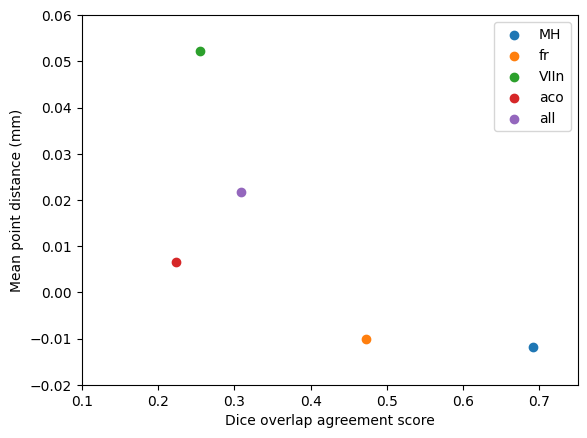

In [209]:
for index, row in best_dice_df.iterrows():
    plt.scatter(row["dice_score"], row["mean"])
plt.xlabel("Dice overlap agreement score")
plt.ylabel("Mean point distance (mm)")
plt.legend(best_dice_df["ccf_label_name"])
plt.xlim([0.1, 0.75])
plt.ylim([-0.02, 0.06])
plt.show()

Text(0.5, 1.0, 'Best dice overlap score by segment')

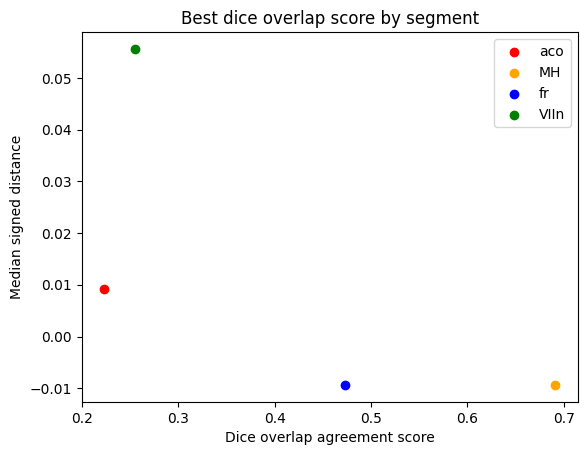

In [64]:
plt.scatter(
    best_dice["aco"]["dice_score"], best_dice["aco"]["median"], color="red"
)
plt.scatter(
    best_dice["MH"]["dice_score"], best_dice["MH"]["median"], color="orange"
)
plt.scatter(
    best_dice["fr"]["dice_score"], best_dice["fr"]["median"], color="blue"
)
plt.scatter(
    best_dice["VIIn"]["dice_score"], best_dice["VIIn"]["median"], color="green"
)
plt.legend(["aco", "MH", "fr", "VIIn"])
plt.xlabel("Dice overlap agreement score")
plt.ylabel("Median signed distance")
plt.title("Best dice overlap score by segment")

In [ ]:
plt.scatter(
    best_dice["aco"]["dice_score"], best_dice["aco"]["mean"], color="red"
)
plt.scatter(
    best_dice["aco"]["dice_score"],
    best_dice["aco"]["abs_mean"],
    color="red",
    marker="x",
)
plt.scatter(
    best_dice["MH"]["dice_score"], best_dice["MH"]["mean"], color="orange"
)
plt.scatter(
    best_dice["MH"]["dice_score"],
    best_dice["MH"]["abs_mean"],
    color="orange",
    marker="x",
)
plt.scatter(
    best_dice["fr"]["dice_score"], best_dice["fr"]["mean"], color="blue"
)
plt.scatter(
    best_dice["fr"]["dice_score"],
    best_dice["fr"]["abs_mean"],
    color="blue",
    marker="x",
)
plt.scatter(
    best_dice["VIIn"]["dice_score"], best_dice["VIIn"]["mean"], color="green"
)
plt.scatter(
    best_dice["VIIn"]["dice_score"],
    best_dice["VIIn"]["abs_mean"],
    color="green",
    marker="x",
)
plt.legend(["aco", "MH", "fr", "VIIn"])
plt.xlabel("Dice overlap agreement score")
plt.ylabel("Mean ")

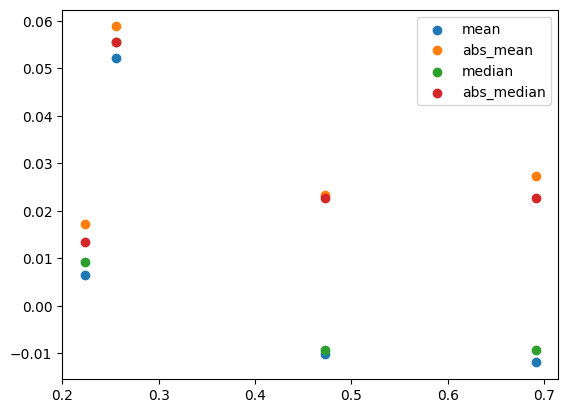

In [40]:
plt.scatter(best_dice_df["dice_score"], best_dice_df["mean"])
plt.scatter(best_dice_df["dice_score"], best_dice_df["abs_mean"])
plt.scatter(best_dice_df["dice_score"], best_dice_df["median"])
plt.scatter(best_dice_df["dice_score"], best_dice_df["abs_median"])
plt.legend(["mean", "abs_mean", "median", "abs_median"])

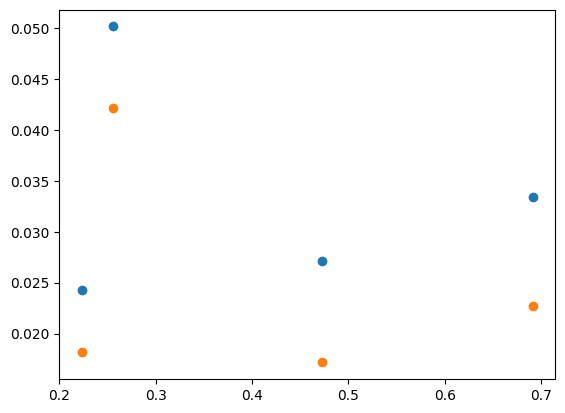

In [41]:
plt.scatter(best_dice_df["dice_score"], best_dice_df["std"])
plt.scatter(best_dice_df["dice_score"], best_dice_df["abs_std"])

## Consider "best" results per point distance measures

In [194]:
best_mean_distance_df = pd.DataFrame([], columns=results_df.columns)

for ccf_label_name in pd.unique(results_df["ccf_label_name"]):
    label_df = results_df[results_df["ccf_label_name"] == ccf_label_name]
    result = label_df[label_df["mean"] == np.min(label_df["mean"])]
    if len(result) > 1:
        _, result = next(label_df.iterrows())
        result = pd.DataFrame(result).transpose()
    best_mean_distance_df = pd.concat([best_mean_distance_df, result])

best_mean_distance_df.head()

,subject_id,channel_id,experiment_id,registration_date,label_value,count,mean,std,min,median,max,abs_mean,abs_std,abs_min,abs_median,abs_max,ccf_label_name,ccf_label_value,dice_score
20,652506,Ex_488_Em_525,LEVEL_4,2023.06.01,473,39309,-0.011932,0.033436,-0.129582,-9.335111e-03,0.087522,0.027307,0.022685,4.897538e-44,0.022753,0.129582,MH,473,0.691117
11,652506,Ex_561_Em_593,ANTS_L4,2023.06.04,585,15346,-0.010834,0.038613,-0.093935,-1.346423e-02,0.079475,0.033116,0.022622,4.897538e-44,0.029991,0.093935,fr,585,0.368210
27,652506,Ex_561_Em_593,LEVEL_4,2023.06.01,788,19894,0.052205,0.050160,-0.067114,5.558640e-02,0.197513,0.058846,0.042173,4.897538e-44,0.055586,0.197513,VIIn,788,0.255246
58,652506,Ex_561_Em_593,LEVEL_3,2023.06.05,890,35861,-0.002529,0.051377,-0.127839,1.469402e-43,0.109212,0.043761,0.027037,4.897538e-44,0.043398,0.127839,aco,890,0.134285
24,652506,Ex_488_Em_525,LEVEL_4,2023.06.01,-1,110045,0.008329,0.052769,-0.132761,1.199792e-43,0.182856,0.041096,0.034133,4.897538e-44,0.033170,0.182856,all,-1,0.265520


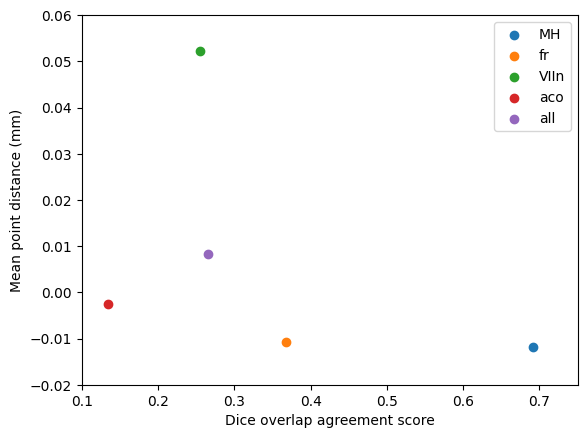

In [208]:
for index, row in best_mean_distance_df.iterrows():
    plt.scatter(row["dice_score"], row["mean"])
plt.xlabel("Dice overlap agreement score")
plt.ylabel("Mean point distance (mm)")
plt.legend(best_mean_distance_df["ccf_label_name"])
plt.xlim([0.1, 0.75])
plt.ylim([-0.02, 0.06])
plt.show()